In [1]:
import numpy as np 
import pandas as pd 
import math
import seaborn as sns
import datetime as dt
from datetime import datetime    
sns.set_style("whitegrid")
from pandas.plotting import autocorrelation_plot
import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use("ggplot")


from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
import matplotlib.pyplot as plt


In [42]:
data = pd.read_csv('./meta.csv')
data.head()

# Reset index
data.reset_index(drop=True, inplace=True)

# Select numeric columns
numeric_data = data.select_dtypes(include=[np.number])

# Fill NaN values in numeric columns with the mean of those columns
data[numeric_data.columns] = data[numeric_data.columns].fillna(numeric_data.mean())

# Display the first few rows of the DataFrame
print(data.head())

# Calculate moving average
ma_day = [5, 10, 20, 50]  # Common short-term and long-term windows
for ma in ma_day:
    column_name = f"MA for {ma} days"
    data[column_name] = data['Close'].rolling(window=ma).mean()

# Calculate Exponential moving average
for ma in ma_day:
    column_name = f"EMA for {ma} days"
    data[column_name] = data['Close'].ewm(span=ma, adjust=False).mean()

# Bollinger Bands
window = 20
data['BB_middle'] = data['Close'].rolling(window=window).mean()
data['BB_upper'] = data['BB_middle'] + 2*data['Close'].rolling(window=window).std()
data['BB_lower'] = data['BB_middle'] - 2*data['Close'].rolling(window=window).std()

# Price changes
data['Price_Change'] = data['Close'].pct_change()
data['Price_Change_5d'] = data['Close'].pct_change(periods=5)
data['Price_Change_21d'] = data['Close'].pct_change(periods=21)

# MACD
exp1 = data['Close'].ewm(span=12, adjust=False).mean()
exp2 = data['Close'].ewm(span=26, adjust=False).mean()
data['MACD'] = exp1 - exp2
data['Signal_Line'] = data['MACD'].ewm(span=9, adjust=False).mean()


# Calculate RSI
def compute_RSI(data, window=14):
    delta = data['Close'].diff()
    gain = (delta.where(delta > 0, 0)).rolling(window=window).mean()
    loss = (-delta.where(delta < 0, 0)).rolling(window=window).mean()
    RS = gain / loss
    return 100 - (100 / (1 + RS))

data['RSI_14'] = compute_RSI(data)

# # Trading Volume Moving Average: Add moving averages for the Volume
# for ma in ma_day:
#     data[f"Volume_MA_{ma}"] = data['Volume'].rolling(window=ma).mean()

data.dropna(inplace=True)
data.head(500)

         Date   Open   High    Low    Close     Volume
0  2012-05-18  42.05  45.00  38.00  38.2318  573576400
1  2012-05-21  36.53  36.66  33.00  34.0300  168192700
2  2012-05-22  32.61  33.59  30.94  31.0000  101786600
3  2012-05-23  31.37  32.50  31.36  32.0000   73600000
4  2012-05-24  32.95  33.21  31.77  33.0300   50237200


,Date,Open,High,Low,Close,Volume,MA for 5 days,MA for 10 days,MA for 20 days,MA for 50 days,...,EMA for 50 days,BB_middle,BB_upper,BB_lower,Price_Change,Price_Change_5d,Price_Change_21d,MACD,Signal_Line,RSI_14
49,2012-07-30,23.995,24.04,23.030,23.15,29285900,26.29800,27.52000,29.237800,29.838636,...,30.538853,29.237800,34.169255,24.306345,-0.023413,-0.194783,-0.261798,-1.525536,-0.894611,15.733114
50,2012-07-31,23.370,23.37,21.610,21.71,56179400,24.95000,26.88200,28.784750,29.508200,...,30.192623,28.784750,34.691542,22.877958,-0.062203,-0.236907,-0.301817,-1.869091,-1.089507,14.602446
51,2012-08-01,21.500,21.58,20.840,20.88,44604400,23.25800,26.05900,28.268750,29.245200,...,29.827422,28.268750,35.028615,21.508885,-0.038231,-0.288344,-0.321439,-2.183168,-1.308239,13.890909
52,2012-08-02,20.770,20.84,19.820,20.04,56374500,21.89700,25.16300,27.697250,29.026000,...,29.443602,27.697250,35.208463,20.186037,-0.040230,-0.253492,-0.357692,-2.471369,-1.540865,13.172414
53,2012-08-03,20.360,22.16,19.900,21.09,80647000,21.37400,24.39600,27.165250,28.807800,...,29.116010,27.165250,34.975085,19.355415,0.052395,-0.110314,-0.329838,-2.585243,-1.749740,22.638623
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
544,2014-07-21,68.810,69.96,68.500,69.40,49431600,67.81096,66.58973,66.626865,64.001716,...,64.769416,66.626865,69.652270,63.601460,0.014325,0.022091,0.078620,1.037495,0.876412,56.251778
545,2014-07-22,69.760,69.77,68.610,69.27,40301800,68.23196,67.24073,66.821865,64.242316,...,64.945909,66.821865,70.004815,63.638915,-0.001873,0.031341,0.073953,1.134074,0.927944,53.726471
546,2014-07-23,69.740,71.33,69.610,71.29,77435900,68.95796,67.87273,67.100365,64.471516,...,65.194697,67.100365,70.808733,63.391997,0.029161,0.053651,0.090561,1.357958,1.013947,64.538726
547,2014-07-24,75.960,76.74,74.510,74.98,124006900,70.67198,68.88348,67.477365,64.774516,...,65.578435,67.477365,72.596013,62.358717,0.051760,0.129049,0.140901,1.812249,1.173608,71.536342


In [43]:
from xgboost import XGBRegressor
from sklearn.preprocessing import RobustScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, Bidirectional, BatchNormalization
from tensorflow.keras.layers import LeakyReLU
from tensorflow.keras.regularizers import L1L2
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.optimizers import Adam
from xgboost import XGBRegressor

# Prepare features and target

# feature_columns = ['Close', 'Volume', 'MA for 50 days', 'EMA for 50 days', 'RSI_14']
# Features and target
features = ['Close', 'Volume', 'MA for 50 days', 'EMA for 50 days', 'RSI_14']
X = data[features]
y = data['Close']

# Split into train and validation sets
train_size = int(len(X) * 0.8)
X_train, X_val = X[:train_size], X[train_size:]
y_train, y_val = y[:train_size], y[train_size:]

# Scale data
scaler = RobustScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)

y_scaler = RobustScaler()
y_train_scaled = y_scaler.fit_transform(y_train.values.reshape(-1, 1))
y_val_scaled = y_scaler.transform(y_val.values.reshape(-1, 1))

# XGBoost model
xgb_params = {
    'n_estimators': 300,
    'learning_rate': 0.01,
    'max_depth': 6,
    'subsample': 0.8,
    'colsample_bytree': 0.8,
    'random_state': 42
}
xgb_model = XGBRegressor(**xgb_params)
xgb_model.fit(X_train_scaled, y_train_scaled.ravel())


# XGBoost predictions
xgb_train_pred = xgb_model.predict(X_train_scaled)
xgb_val_pred = xgb_model.predict(X_val_scaled)

# Combine XGBoost features for LSTM
train_combined = np.column_stack((X_train_scaled, xgb_train_pred))
val_combined = np.column_stack((X_val_scaled, xgb_val_pred))

In [44]:
import tensorflow as tf
from tensorflow.keras.layers import Conv1D, LSTM, Dense, Dropout, Bidirectional, TimeDistributed
from tensorflow.keras.layers import MaxPooling1D, Flatten, BatchNormalization, LeakyReLU
from tensorflow.keras.regularizers import L1L2
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.optimizers import Adam


# Create sequences for LSTM
sequence_length = 60

def create_sequences(data, target, seq_len):
    sequences = []
    targets = []
    for i in range(len(data) - seq_len):
        sequences.append(data[i:i + seq_len])
        targets.append(target[i + seq_len])
    return np.array(sequences), np.array(targets)

X_train_seq, y_train_seq = create_sequences(train_combined, y_train_scaled, sequence_length)
X_val_seq, y_val_seq = create_sequences(val_combined, y_val_scaled, sequence_length)

# LSTM model
lstm_model = Sequential([
    Bidirectional(LSTM(128, return_sequences=True, kernel_regularizer=L1L2(0.01, 0.01), input_shape=(X_train_seq.shape[1], X_train_seq.shape[2]))),
    BatchNormalization(),
    Dropout(0.3),
    
    Bidirectional(LSTM(64, return_sequences=False, kernel_regularizer=L1L2(0.01, 0.01))),
    BatchNormalization(),
    Dropout(0.3),
    
    Dense(32, activation='relu'),
    Dense(1)
])

lstm_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), loss='mse', metrics=['mse', 'mae'])

# Callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
lr_reducer = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=1e-5)

# Train the LSTM model
history = lstm_model.fit(
    X_train_seq, y_train_seq,
    epochs=50,
    batch_size=32,
    validation_data=(X_val_seq, y_val_seq),
    callbacks=[early_stopping, lr_reducer]
)


Epoch 1/50


c:\Users\timoz\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


64/64 ━━━━━━━━━━━━━━━━━━━━ 13s 95ms/step - loss: 69.9957 - mae: 0.8667 - mse: 1.3756 - val_loss: 37.6596 - val_mae: 1.3195 - val_mse: 2.3612 - learning_rate: 0.0010
Epoch 2/50
64/64 ━━━━━━━━━━━━━━━━━━━━ 6s 88ms/step - loss: 27.7296 - mae: 0.4524 - mse: 0.3223 - val_loss: 13.0510 - val_mae: 1.1903 - val_mse: 2.0292 - learning_rate: 0.0010
Epoch 3/50
64/64 ━━━━━━━━━━━━━━━━━━━━ 5s 81ms/step - loss: 9.0080 - mae: 0.3535 - mse: 0.1968 - val_loss: 6.4486 - val_mae: 1.1353 - val_mse: 1.9021 - learning_rate: 0.0010
Epoch 4/50
64/64 ━━━━━━━━━━━━━━━━━━━━ 5s 82ms/step - loss: 3.9870 - mae: 0.3086 - mse: 0.1563 - val_loss: 4.3665 - val_mae: 1.2232 - val_mse: 2.1049 - learning_rate: 0.0010
Epoch 5/50
64/64 ━━━━━━━━━━━━━━━━━━━━ 5s 85ms/step - loss: 2.0547 - mae: 0.2630 - mse: 0.1131 - val_loss: 3.6607 - val_mae: 1.3226 - val_mse: 2.4044 - learning_rate: 0.0010
Epoch 6/50
64/64 ━━━━━━━━━━━━━━━━━━━━ 5s 82ms/step - loss: 1.2881 - mae: 0.2667 - mse: 0.1231 - val_loss: 2.5716 - val_mae: 1.0814 - val_mse:

In [45]:
# Make predictions
# lstm_predictions = lstm_model.predict(X_sequences)
# final_predictions = y_scaler.inverse_transform(lstm_predictions)

# Evaluate model
lstm_val_pred = lstm_model.predict(X_val_seq)
lstm_val_pred = y_scaler.inverse_transform(lstm_val_pred)
y_val_actual = y_scaler.inverse_transform(y_val_seq)

15/15 ━━━━━━━━━━━━━━━━━━━━ 2s 89ms/step


15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 39ms/step

Performance Metrics:
MSE: 386.25
RMSE: 19.65
MAE: 15.49
R2 Score: 0.9500


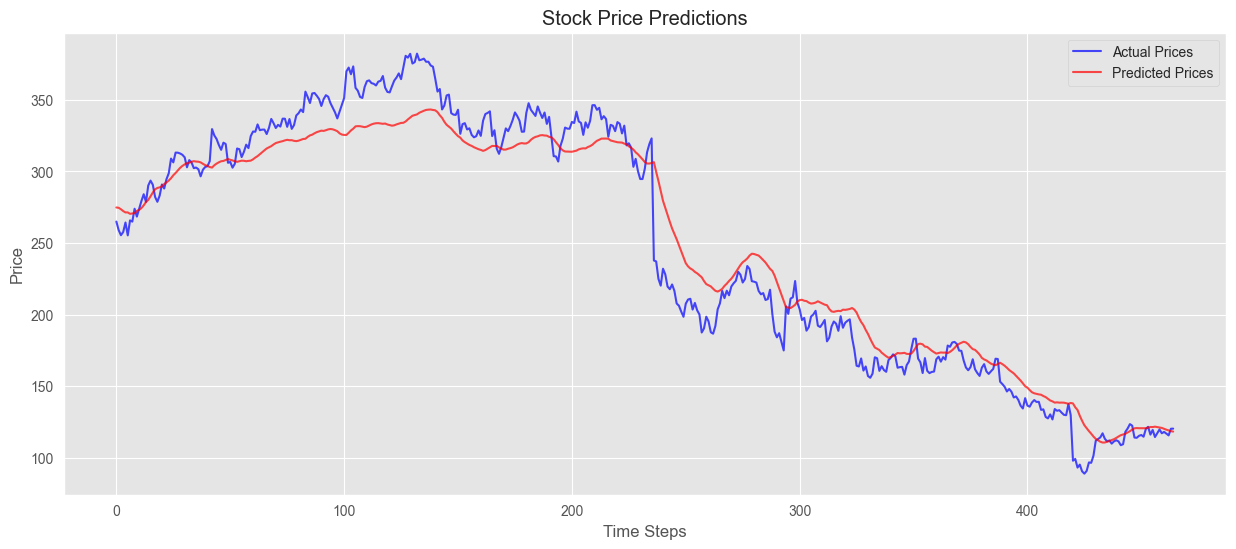

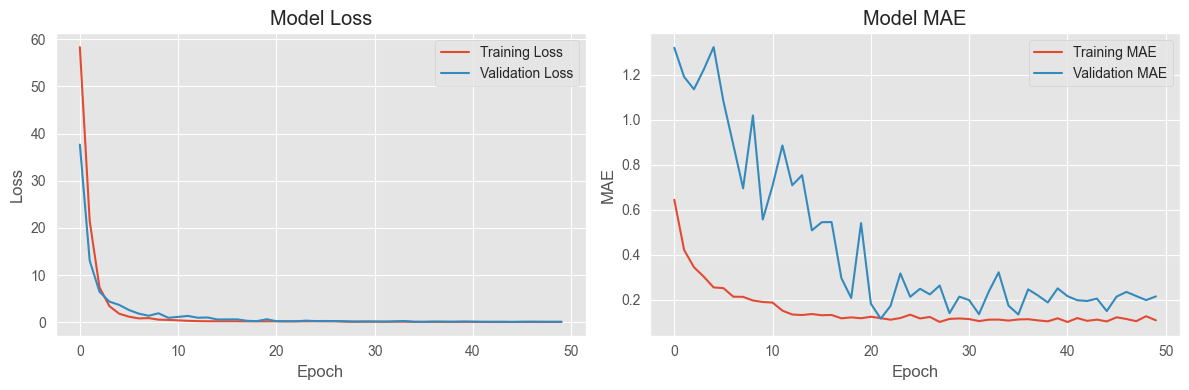

In [46]:
# from sklearn.metrics import mean_squared_error, mean_absolute_error

# from sklearn.metrics import explained_variance_score, mean_poisson_deviance, mean_gamma_deviance
# from sklearn.metrics import r2_score
# from sklearn.metrics import max_error


# # Get actual values
# # actual_values = y[sequence_length:]
# # split_idx = int(len(actual_values) * 0.8)
# # val_actual = actual_values[split_idx:]
# # val_predictions = final_predictions[split_idx:]

# # Calculate metrics
# mse = mean_squared_error(val_actual, val_predictions)
# rmse = np.sqrt(mse)
# mae = mean_absolute_error(val_actual, val_predictions)
# r2 = r2_score(val_actual, val_predictions)

# print("\nPerformance Metrics:")
# print(f"MSE: {mse:.2f}")
# print(f"RMSE: {rmse:.2f}")
# print(f"MAE: {mae:.2f}")
# print(f"R2 Score: {r2:.4f}")

# # Plot results
# plt.figure(figsize=(15, 6))
# plt.plot(val_actual, label='Actual Stock Price', color='blue', alpha=0.8)
# plt.plot(val_predictions, label='Predicted Stock Price', color='red', alpha=0.8)
# plt.title('Stock Price Prediction on Validation Set')
# plt.xlabel('Time Steps')
# plt.ylabel('Price ($)')
# plt.legend()
# plt.grid(True)
# plt.show()

# # Plot training history
# plt.figure(figsize=(12, 4))
# plt.subplot(1, 2, 1)
# plt.plot(history.history['loss'], label='Training Loss')
# plt.plot(history.history['val_loss'], label='Validation Loss')
# plt.title('Model Loss')
# plt.xlabel('Epoch')
# plt.ylabel('Loss')
# plt.legend()

# plt.subplot(1, 2, 2)
# plt.plot(history.history['mae'], label='Training MAE')
# plt.plot(history.history['val_mae'], label='Validation MAE')
# plt.title('Model MAE')
# plt.xlabel('Epoch')
# plt.ylabel('MAE')
# plt.legend()
# plt.tight_layout()
# plt.show()

# Evaluate model
# lstm_val_pred = lstm_model.predict(X_val_seq)
# lstm_val_pred = y_scaler.inverse_transform(lstm_val_pred)
# y_val_actual = y_scaler.inverse_transform(y_val_seq)

mse = mean_squared_error(y_val_actual, lstm_val_pred)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_val_actual, lstm_val_pred)
r2 = r2_score(y_val_actual, lstm_val_pred)

print("\nPerformance Metrics:")
print(f"MSE: {mse:.2f}")
print(f"RMSE: {rmse:.2f}")
print(f"MAE: {mae:.2f}")
print(f"R2 Score: {r2:.4f}")

# Plot predictions
plt.figure(figsize=(15, 6))
plt.plot(y_val_actual, label='Actual Prices', color='blue', alpha=0.7)
plt.plot(lstm_val_pred, label='Predicted Prices', color='red', alpha=0.7)
plt.title('Stock Price Predictions')
plt.xlabel('Time Steps')
plt.ylabel('Price')
plt.legend()
plt.grid(True)
plt.show()

# Plot training history
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['mae'], label='Training MAE')
plt.plot(history.history['val_mae'], label='Validation MAE')
plt.title('Model MAE')
plt.xlabel('Epoch')
plt.ylabel('MAE')
plt.legend()

plt.tight_layout()
plt.show()


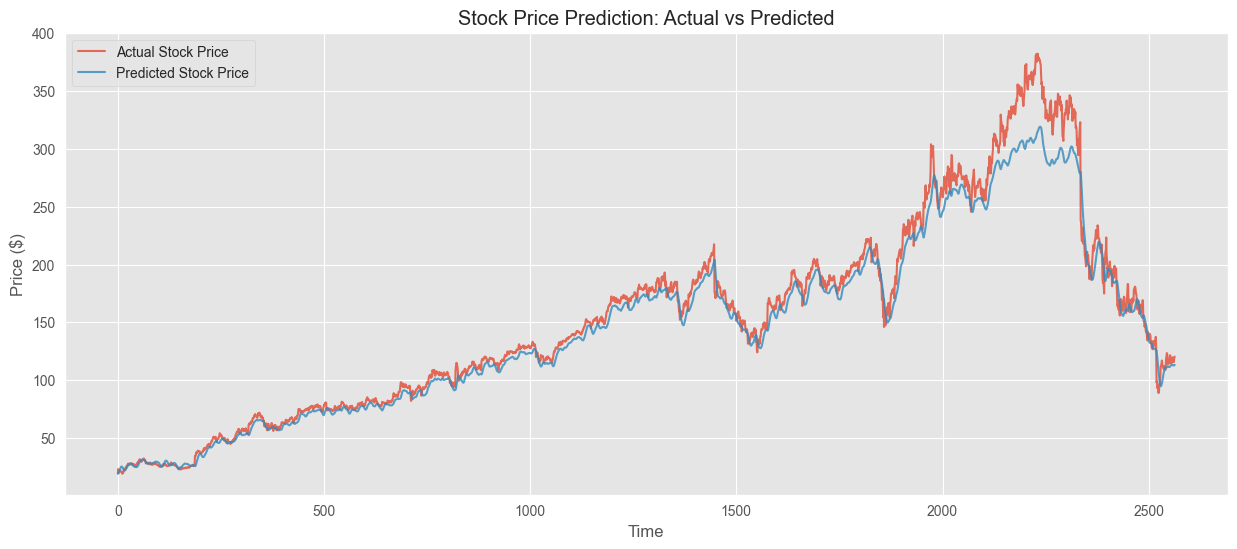

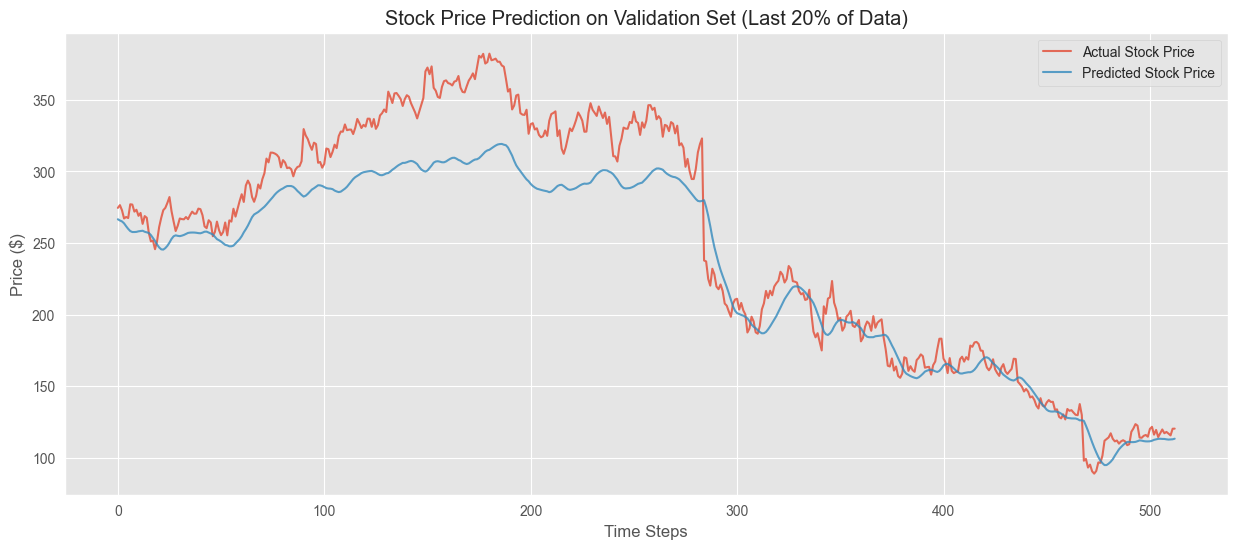

In [7]:
# Plot results
plt.figure(figsize=(15, 6))
plt.plot(actual_values, label='Actual Stock Price', alpha=0.8)
plt.plot(final_predictions, label='Predicted Stock Price', alpha=0.8)
plt.title('Stock Price Prediction: Actual vs Predicted')
plt.xlabel('Time')
plt.ylabel('Price ($)')
plt.legend()
plt.grid(True)
plt.show()

# Plot only the validation results
plt.figure(figsize=(15, 6))
plt.plot(val_actual, label='Actual Stock Price', alpha=0.8)
plt.plot(val_predictions, label='Predicted Stock Price', alpha=0.8)
plt.title('Stock Price Prediction on Validation Set (Last 20% of Data)')
plt.xlabel('Time Steps')
plt.ylabel('Price ($)')
plt.legend()
plt.grid(True)
plt.show()

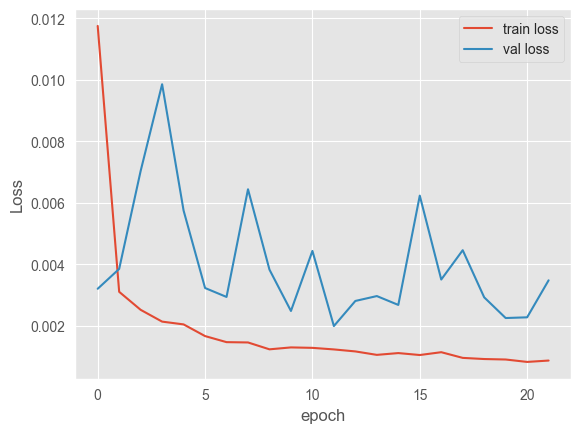

In [8]:
# loss
plt.plot(history.history['loss'], label='train loss')
plt.plot(history.history['val_loss'], label='val loss')
plt.xlabel("epoch")
plt.ylabel("Loss")
plt.legend()



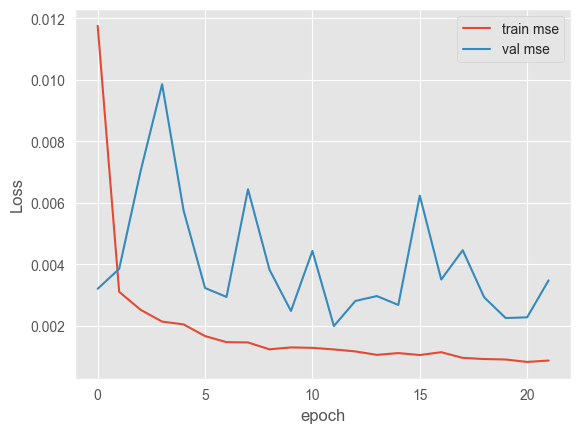

In [9]:
# mse
plt.plot(history.history['mse'], label='train mse')
plt.plot(history.history['val_mse'], label='val mse')
plt.xlabel("epoch")
plt.ylabel("Loss")
plt.legend()



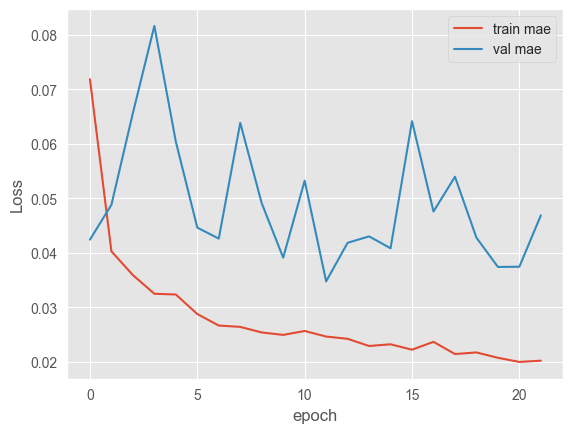

In [10]:
# mae
plt.plot(history.history['mae'], label='train mae')
plt.plot(history.history['val_mae'], label='val mae')
plt.xlabel("epoch")
plt.ylabel("Loss")
plt.legend()


Model Performance Metrics:
MSE: 34.36427574631958
RMSE: 5.862105061010045
MAE: 3.698693910817163
R2 Score: 0.9952357319043761


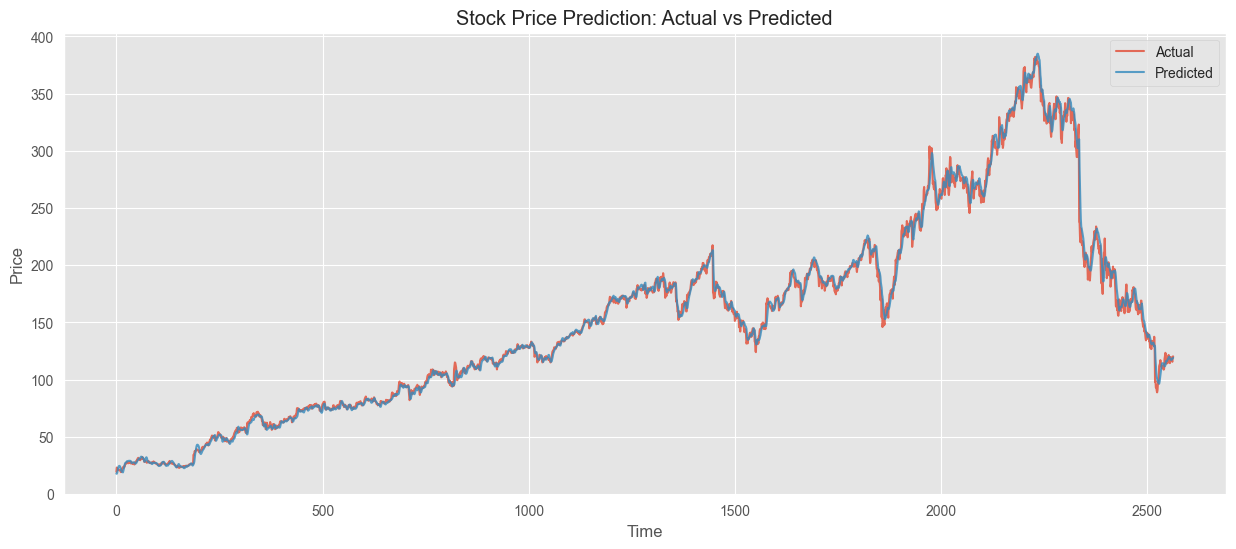

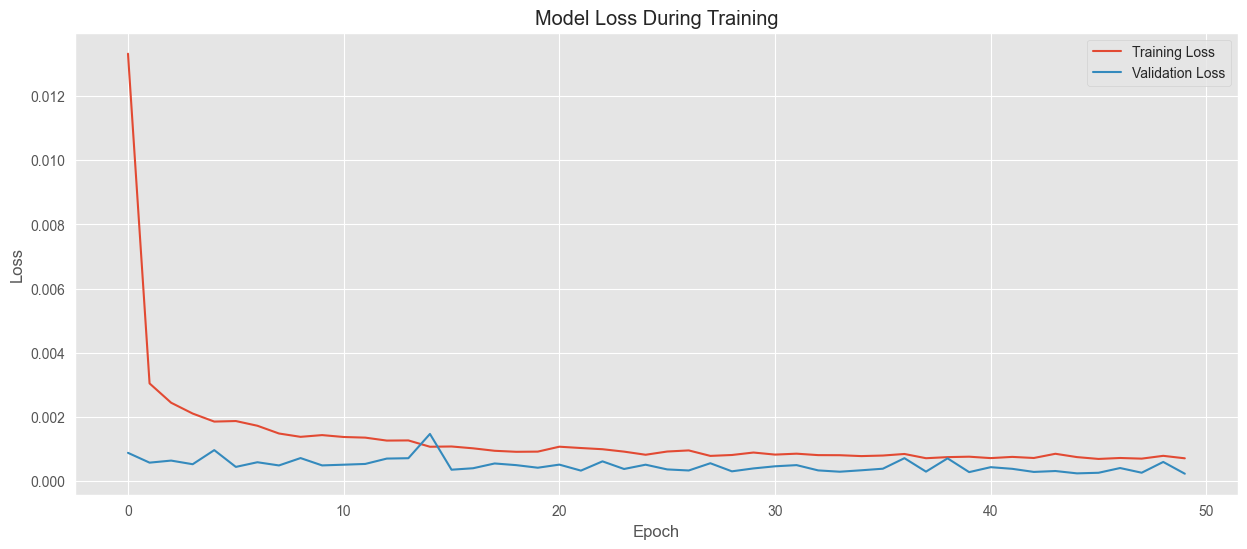

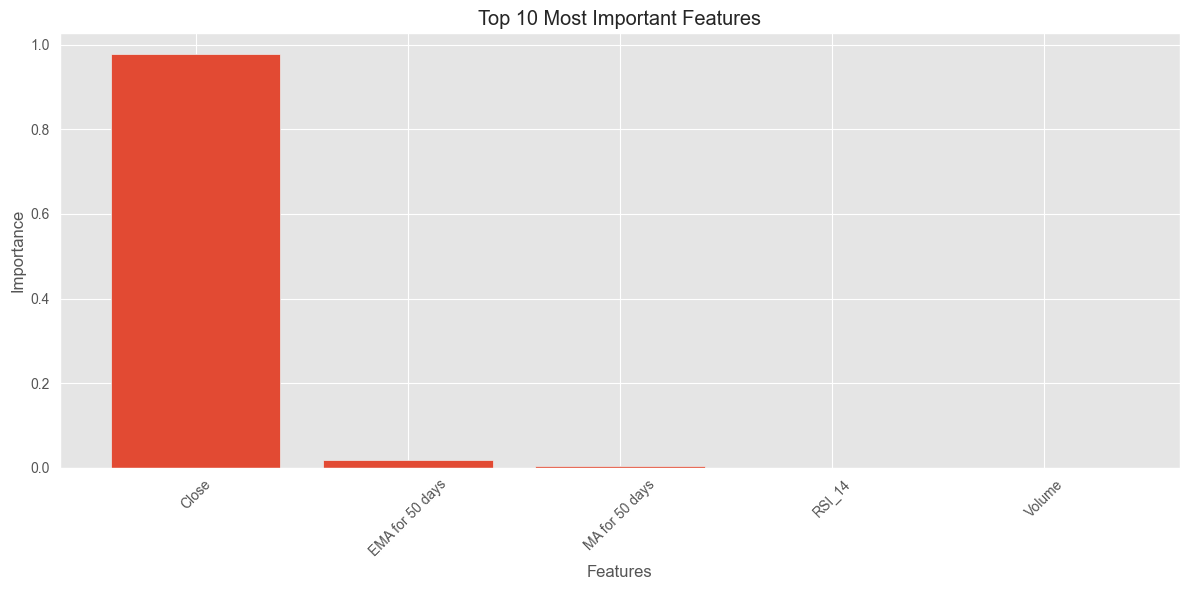

In [15]:
# old code

from sklearn.metrics import mean_squared_error, mean_absolute_error

from sklearn.metrics import explained_variance_score, mean_poisson_deviance, mean_gamma_deviance
from sklearn.metrics import r2_score
from sklearn.metrics import max_error


# Calculate metrics
actual_values = y[sequence_length:]
mse = mean_squared_error(actual_values, final_predictions)
rmse = np.sqrt(mse)
mae = mean_absolute_error(actual_values, final_predictions)
r2 = r2_score(actual_values, final_predictions)

print("\nModel Performance Metrics:")
print(f"MSE: {mse}")
print(f"RMSE: {rmse}")
print(f"MAE: {mae}")
print(f"R2 Score: {r2}")

# Plot results
plt.figure(figsize=(15, 6))
plt.plot(actual_values, label='Actual', alpha=0.8)
plt.plot(final_predictions, label='Predicted', alpha=0.8)
plt.title('Stock Price Prediction: Actual vs Predicted')
plt.xlabel('Time')
plt.ylabel('Price')
plt.legend()
plt.grid(True)
plt.show()

# Plot training history
plt.figure(figsize=(15, 6))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss During Training')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

# Feature importance analysis
feature_importance = pd.DataFrame({
    'feature': feature_columns,
    'importance': xgb_model.feature_importances_
})
feature_importance = feature_importance.sort_values('importance', ascending=False)

plt.figure(figsize=(12, 6))
plt.bar(feature_importance['feature'][:10], feature_importance['importance'][:10])
plt.xticks(rotation=45)
plt.title('Top 10 Most Important Features')
plt.xlabel('Features')
plt.ylabel('Importance')
plt.tight_layout()
plt.show()
